In [1]:
#import all relevant packages
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F
from mpl_toolkits.axes_grid1 import AxesGrid
import mpl_toolkits as mpl
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["mpl_toolkits.legacy_colorbar"] = False


s=10
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


MNIST_train = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=True,
        download=True,
        transform=MNIST_transform)


MNIST_test = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform)

In [3]:
mnist_train_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_train,
    batch_size=128,
    shuffle=True
)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=128,
    shuffle=False,
)



# Defining networks

In [4]:
# Network for inputfeed of linear layer
class Net_no_linear(nn.Module):
    def __init__(self):
        super(Net_no_linear, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        #self.fc1 = nn.Linear(4*4*32, 10)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        #x = x.view(-1, 4*4*32)
        return x

#Network for activations with linear layer (whole network)
class Net_with_linear(nn.Module):
    def __init__(self):
        super(Net_with_linear, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4*4*32, 10)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = x.view(-1, 4*4*32)
        return x
    
#Network for inputfeed of the second conv_layer   
class Net_second_conv(nn.Module):
    def __init__(self):
        super(Net_second_conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.maxpool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(32, 32, 5)
        #self.maxpool2 = nn.MaxPool2d(2, 2)
        #self.fc1 = nn.Linear(4*4*32, 10)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        #x = self.maxpool(F.relu(self.conv2(x)))
        #x = x.view(-1, 4*4*32)
        return x

In [5]:
mnist_model_no_linear = Net_no_linear()
mnist_model_with_linear = Net_with_linear()
mnist_model_second_conv = Net_second_conv()
loss_function = nn.CrossEntropyLoss()



In [51]:
MNIST_PATH = "../trained_weights/MNIST/MNIST_weights_seed={}.pth".format(s)


mnist_model_second_conv.load_state_dict(torch.load(MNIST_PATH), strict=False)
mnist_model_second_conv.eval()

mnist_model_no_linear.load_state_dict(torch.load(MNIST_PATH), strict=False)
mnist_model_no_linear.eval()

mnist_model_with_linear.load_state_dict(torch.load(MNIST_PATH), strict=False)
mnist_model_with_linear.eval()



Net_with_linear(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

# The first conv layer

## Inputfeed of first conv layer

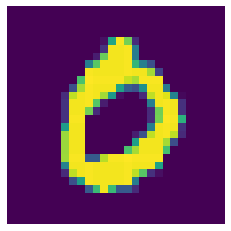

In [52]:
plt.imshow(MNIST_test.data[3])
plt.axis('off')
plt.show()

## activations of first conv layer

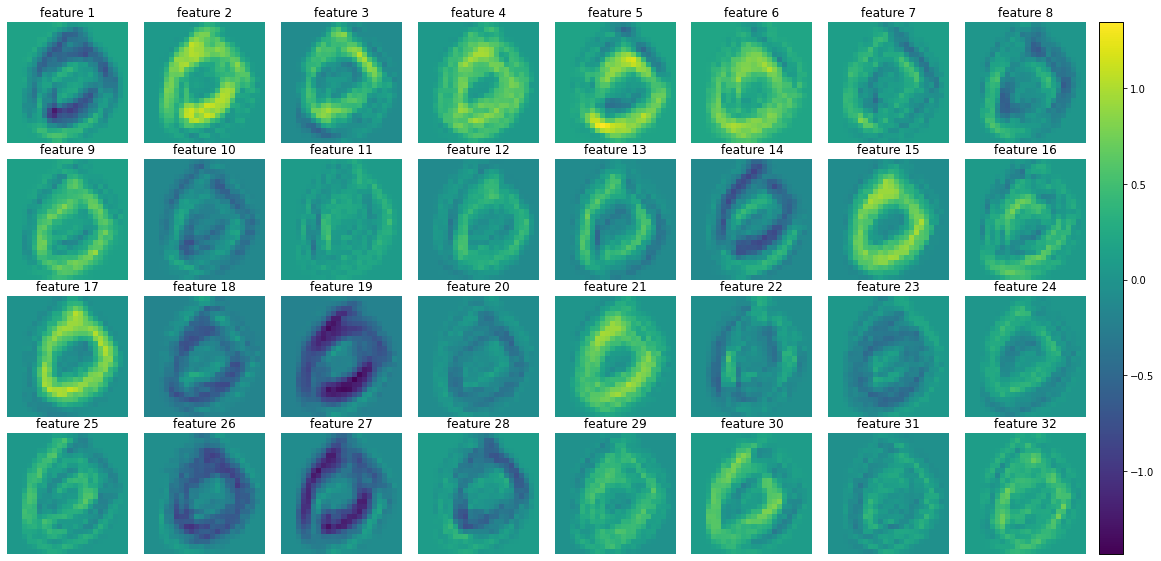

In [53]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

mnist_model_with_linear.conv1.register_forward_hook(get_activation('conv1'))
data, _ = MNIST_test[3]
data.unsqueeze_(0)
output = mnist_model_with_linear(data)

act = activation['conv1'].squeeze()

fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = min(list(torch.flatten(act).detach().numpy()))
max_val = max(list(torch.flatten(act).detach().numpy()))
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(act[i], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 0.1))
plt.show()

(-0.5, 23.5, 23.5, -0.5)

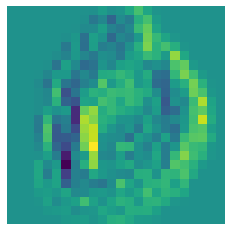

In [54]:
plt.imshow(act[10])
plt.axis('off')

# The second conv layer

## Input feed of second conv layer

torch.Size([1, 32, 12, 12])


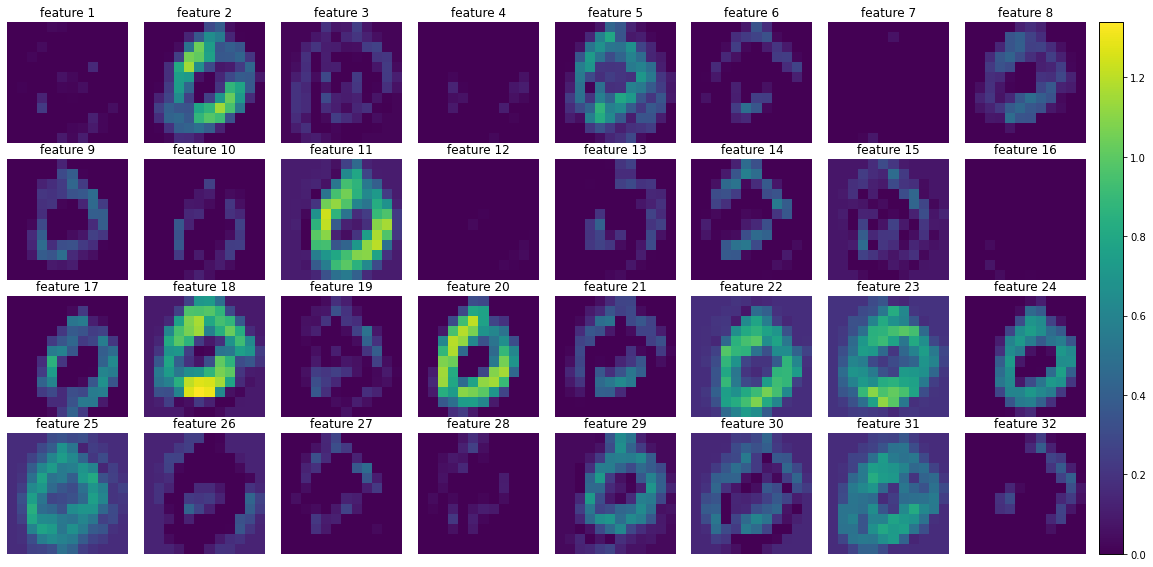

In [55]:
data, _ = MNIST_test[3]
data.unsqueeze_(0)
output = mnist_model_second_conv(data)
print(output.size())
#print(output[0][31])
inputfeed = output.detach().numpy()

fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = min(list(torch.flatten(output).detach().numpy()))
max_val = max(list(torch.flatten(output).detach().numpy()))
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(inputfeed[0][i], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 0.1))
plt.show()

(-0.5, 11.5, 11.5, -0.5)

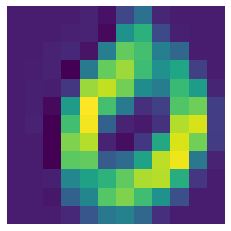

In [56]:
plt.imshow(inputfeed[0][10])
plt.axis('off')

## activations of second conv layer

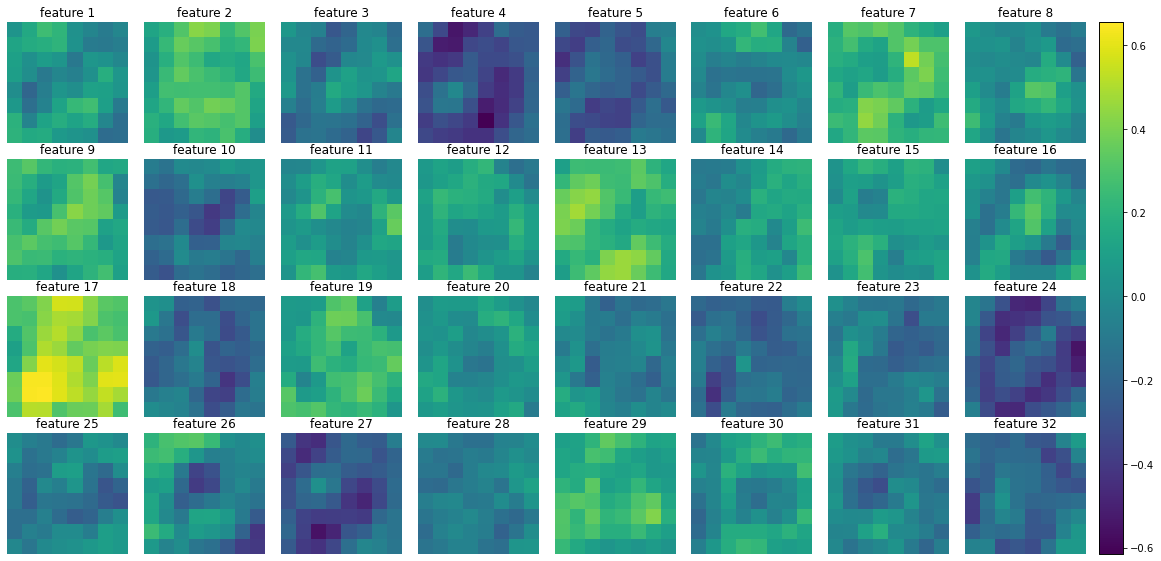

In [57]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

mnist_model_with_linear.conv2.register_forward_hook(get_activation('conv2'))
data, _ = MNIST_test[3]
data.unsqueeze_(0)
output = mnist_model_with_linear(data)

act = activation['conv2'].squeeze()

fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = min(list(torch.flatten(act).detach().numpy()))
max_val = max(list(torch.flatten(act).detach().numpy()))
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(act[i], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 0.1))
plt.show()

(-0.5, 7.5, 7.5, -0.5)

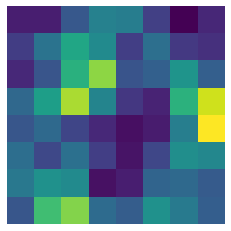

In [58]:
plt.imshow(act[10])
plt.axis('off')

# The linear layer

## Input feed of the linear layer

torch.Size([1, 32, 4, 4])


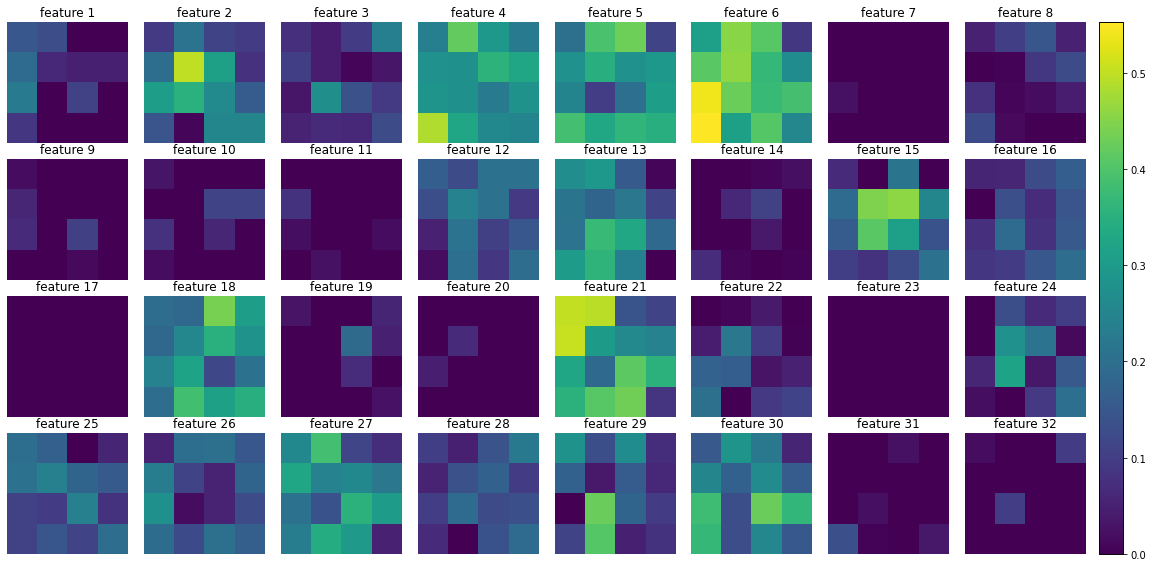

In [59]:
data, _ = MNIST_test[3]
data.unsqueeze_(0)
output = mnist_model_no_linear(data)
print(output.size())
#print(output[0][31])
inputfeed = output.detach().numpy()

fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = min(list(torch.flatten(output).detach().numpy()))
max_val = max(list(torch.flatten(output).detach().numpy()))
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(inputfeed[0][i], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 0.1))
plt.show()

(-0.5, 3.5, 3.5, -0.5)

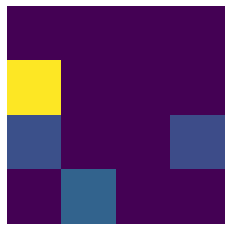

In [60]:
plt.imshow(inputfeed[0][10])
plt.axis('off')

## Activations of linear layer

torch.Size([1, 512])


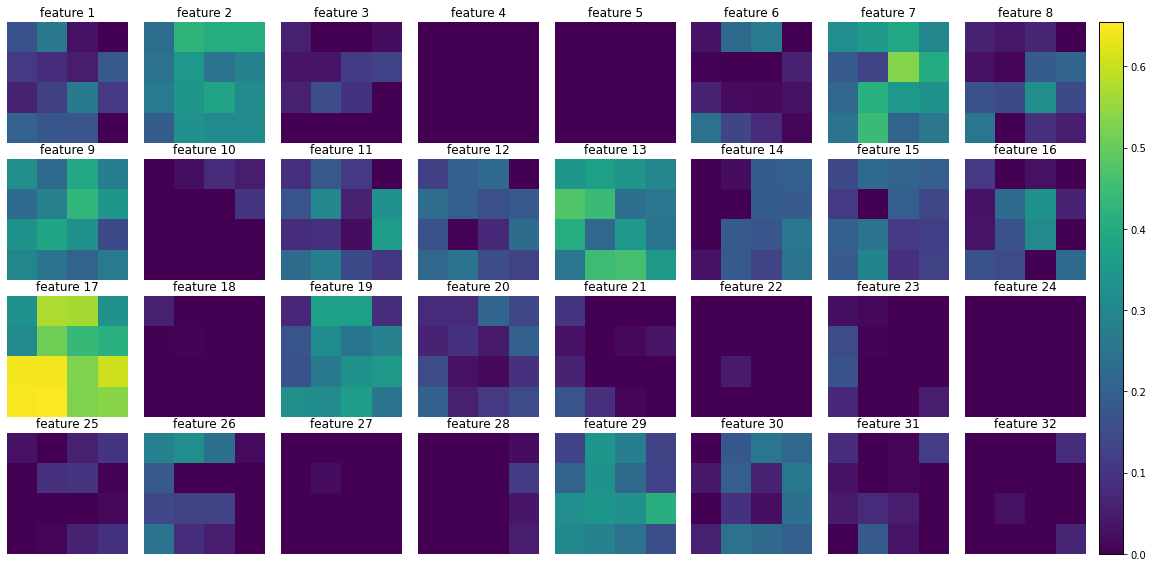

In [61]:
data, _ = MNIST_test[3]
data.unsqueeze_(0)
output = mnist_model_with_linear(data)
print(output.size())
#print(output[0][31])
outputfeed = output.detach().numpy()

output_split = np.array_split(np.array(outputfeed[0]), 32)
for i in range(len(output_split)-1):
    output_split[i] = np.reshape(output_split[i], (4, -1))
#print(output_split.size)
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = min(list(torch.flatten(output).detach().numpy()))
max_val = max(list(torch.flatten(output).detach().numpy()))
for i, ax in enumerate(grid):
    output_split[i] = np.reshape(output_split[i], (4, -1))
    ax.set_axis_off()
    im = ax.imshow(output_split[i], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 0.1))
plt.show()

(-0.5, 3.5, 3.5, -0.5)

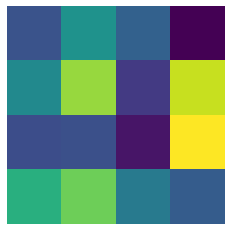

In [62]:
plt.imshow(output_split[10])
plt.axis('off')